# 8-Blockchain. Lab1
Варіант 8

Михайло Корешков, ФІ-91

**Мета роботи:** Дослiдження особливостей атаки подвiйних витрат.

In [1]:
import numpy as np
import scipy as sp
import scipy.optimize
import matplotlib.pyplot as plt

import timeit
import time

import mpmath as mp

Варіант 8:

```
alpha_H = 7.5e-4
alpha_M = 3.5e-4  
alpha = alpha_H + alpha_M = 1.1e-3  
D_H = 45s
```

Тут ми розглядаємо протокол Proof of Work (надалі PoW). За умов цього протоколу, всі майнери будують наступний блок транзакцій одночасно, але сам цей процес займає багато часу (суттєво більше за час синхронизації). Також, оскільки процес створення нового блоку (надалі майнінг) значною мірою опирається на криптографічно стійку хеш-функцію, час генерації нового блоку - це все-таки випадкова величина. Ймовірність випуску блока майнером пропорційна об'єму його обчислювальних потужностей.

Суть DS атаки полягає в наступному:
1. Зловмисник публікує транзацію, в якій сплачує за товари чи послуги вендору
2. Зловмисник починає створювати альтернативну гілку блокчейну, в якій цієї транзакції не відбулося
3. Якщо після проходження часу підтверження і отримання товару чи послуги від вендора зловмисник встиг згенерувати більше блоків в альтернативній гілці, ніж в основній, то він публікує цю альтернативну гілку. За правилами, чесні майнери тепер мають вважати альтернативну гілку дійсною.
4. В результаті зловмисник і отримав товар чи послугу від вендора, і відмінив транзакцію, якою за них сплатив -- а отже, може витратити криптовалюту ще раз (звідси і назва атаки)

Математична модель:

- Час є неперервним
- Створення нових блоків описується випадковими процесами Пуасона з відповідною інтенсивністю `alpha_H` для чесних (honest) майнерів та `alpha_M` для зловмисних (malicious) майнерів
- Протокол вимагає від вендора чекати принаймні `z` наступних блоків перед тим, як вважати транзакцію дійсною
- `alpha = alpha_H + alpha_M` - сумарна інтенсивність випуску нових блоків у блокчейні
- `D_H` - типовий час синхронизації між чесними майнерами в секундах


---

## Завдання 1
> Обчислити порiг стiйкостi $p_{st}$ (мiнiмальну частку зловмисних майнерiв, яка гарантує, що
ймовiрнiсть атаки подвiйної витрати буде дорiвнювати 1) для заданих значень iнтенсивностi
створення блокiв чесними майнерами $\alpha_H$ та зловмисними майнерами $\alpha_M$.

Згідно Теореми 1 з [[1]](#res1),
$$1 - p_{st} = \frac{e^{\gamma \cdot p_{st}}}{2}$$ 

де $\gamma = \gamma(\alpha, \Delta) = \alpha \cdot \Delta$.

$\alpha$ - інтенсивність випуску нових блоків. $\Delta$ - цікавий для нас часовий інтервал у секундах. У нашому випадку візьмемо $\Delta = D_H$ (згідно [[1]](#res1), це значення відповідає $\gamma$ за нульового часу синхронизації зловмисних майнерів).



Маємо нелінійне рівняння. Я буду розв'язувати його як задачу пошуку кореня неперервної функції

$$f(x) = 1 - x - \frac{e^{\gamma \cdot x}}{2} = 0$$

Спочатку досліджу функцію графічно, а потім використаю готові алгоримти пошуку коренів з пакету `scipy.optimize`

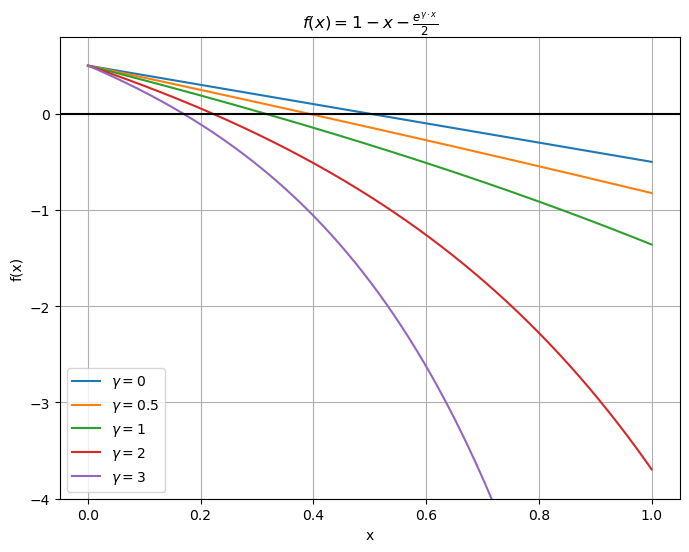

In [2]:
def pst_eq(x, gamma=1): return 1-x-np.exp(gamma*x)/2

X = np.linspace(0,1,1000)
for g in [0, 0.5, 1, 2, 3]:
    plt.plot(X, pst_eq(X, g), label=f'$\gamma={g}$')
plt.grid()
plt.legend()
plt.ylim(-4, 0.8)
plt.title("$f(x) = 1 - x - \\frac{e^{\\gamma \\cdot x}}{2}$")
plt.axhline(0, c='k')
plt.xlabel('x'), plt.ylabel('f(x)')
plt.gcf().set_size_inches(8,6)

Функція `solve_pst_eq(gamma)` приймає на вхід значення `gamma` та повертає знайдений корень вищевказаного рівняння.

Бібліотечна функція 'sp.optimize.root_scalar' з заданими параметрами буде використовувати один з наступних методів на власний розсуд: 
- 'Basic bisection routine'
- 'Classic Brent’s method'
- 'Brent’s method with hyperbolic extrapolation'
- 'TOMS Algorithm 748 method'
- 'Ridder’s method'

$f$ - "гарна", монотонна та неперервно диференційовна достатньо разів функція, що відносно просто обчислюється, отож підходить будь-який метод

In [3]:
def solve_pst_eq(gamma):
    root = sp.optimize.root_scalar(f=pst_eq, args=(gamma), method=None, bracket=(0.0, 1.0))
    return root

print("Приклад обчислення для gamma=2")
solve_pst_eq(2)

Приклад обчислення для gamma=2


      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 0.2214272005011943

Відповідь збігається з тим, що ми бачимо на графіку вище

Обчислення для мого варіанту:

In [4]:
alpha_H = 7.5e-4
alpha_M = 3.5e-4  
alpha = alpha_H + alpha_M
D_H = 45

In [5]:
gamma = alpha * D_H
print("gamma = ", gamma)
p_st = solve_pst_eq(gamma).root
print("p_st = ", p_st)
print("f(p_st) = ", pst_eq(p_st, gamma))

gamma =  0.0495
p_st =  0.4877805054623856
f(p_st) =  1.1102230246251565e-16


**Отже**, для варіанту 8 
$$p_{st} = 0.4878$$

---

## Завдання 2
> Для заданих значень iнтенсивностi створення блокiв чесними майнерами $\alpha_H$ та
зловмисними майнерами $\alpha_M$, а також заданого часу синхронiзацiї $D_H$, обчислити
залежнiсть ймовiрностi, що гiлка, створена зловмисниками, стане довшою за гiлку чесних
майнерiв, якщо в момент розгалуження гiлка чесних майнерiв була довшою на $n$ блокiв,
вiд значення $n$. Побудувати вiдповiдну таблицю розрахункiв та графiк залежностi
ймовiрностi в залежностi вiд значення $n$.

До попередньо зазначеної математичної моделі явно додаємо нульовий час синхронизації для зловмисних майнерів ($D_M = 0$`)

<!-- Нехай $A(n)$ - випадкова величина рівна кількості блоків, яку встиг згенерувати (та опублікувати, оскільки $D_M = 0$) зловмисник до того моменту, як чесні майнери опублікували блок під номером $n$.
> $A(n)$ відповідає величині $X'_M(n)$ у [2], eq (12) -->

За [[2]](#res1), шукана ймовірність дорівнює
$$p(n) = \begin{cases}
1, & p'_M \ge p'_H \\
1 - \sum_{k=0}^{n-1} P_n(k) \left(1 - \beta^{n-k}\right), & otherwise
\end{cases}$$

де 
- $p'_M = 1 - e^{-\alpha_M D_H} \cdot p_H\quad$ -- ефективний хешрейт зловмисника з врахуванням часу синхронизації
- $p'_H = e^{-\alpha_M D_H} \cdot p_H\quad$ -- ефективний хешрейт чесних майнерів
- $\beta = \frac{p'_M}{p'_H}$
- $p_M = \frac{\alpha_M}{\alpha_M + \alpha_H} = 1-p_H$

та
$$P_n(k) = \frac{p_H^n}{(n-1)!}\cdot \frac{e^{-n \alpha_M D_H}\cdot (n \alpha_M D_h)^k}{k!} \cdot 
\sum_{i=0}^k \frac{(n+i-1)!C_k^i}{(n\alpha D_H)^i}$$


In [6]:
# 1. Обчислення P_n(k) та p(n) напряму, (майже) без оптимізацій та динамічного програмування

def Pnk_brute(A_h, A_m, D_h, N, K):
    alpha = A_h + A_m
    p_h = A_h / alpha

    coef = (np.float_power(p_h, N)/sp.special.factorial(N-1)) * (np.exp(-N*A_m*D_h) * np.float_power(N*A_m*D_h, K) / sp.special.factorial(K))
    ii = np.arange(0, K+1)
    summands = sp.special.factorial(N+ii-1) * sp.special.comb(K, ii) / np.float_power(N*alpha*D_h, ii)
    return coef * summands.sum()

def Pn_brute(A_h, A_m, D_h, N):
    p_h = A_h / alpha
    beta = (np.exp(+A_m*D_h) / p_h) - 1
    if beta > 1: 
        return 1

    sum = 1
    for k in range(0, N):
        sum -= (Pnk_brute(A_h, A_m, D_h, N, k) * (1 - np.float_power(beta, N-k)))
    return sum

In [7]:
def calculate_Pn_array(n_max=100):
    nn = np.arange(1,n_max+1)
    pp = np.zeros_like(nn, np.float64)
    for idx, n in enumerate(nn):
        v = Pn_brute(alpha_H, alpha_M, D_H, n)
        # print(v)
        pp[idx] = v
    
    return nn, pp


In [8]:
timeit.timeit(calculate_Pn_array, number=1)

C:\Users\mkrooted\AppData\Local\Temp\ipykernel_16452\1733628209.py:9: RuntimeWarning: overflow encountered in multiply
  summands = sp.special.factorial(N+ii-1) * sp.special.comb(K, ii) / np.float_power(N*alpha*D_h, ii)


0.21174410000003263

In [9]:
T = timeit.timeit(calculate_Pn_array, number=20)

C:\Users\mkrooted\AppData\Local\Temp\ipykernel_16452\1733628209.py:9: RuntimeWarning: overflow encountered in multiply
  summands = sp.special.factorial(N+ii-1) * sp.special.comb(K, ii) / np.float_power(N*alpha*D_h, ii)


In [10]:
T / 20

0.16516214999999193

Спочатку я планував реалізувати декілька способів обчислення $p(n)$: один простий та неефективний, та декілька інших, щоб спробувати різні методи оптимізації обчислень. Але навіть проста функція виявилась швидше, ніж я припускав.

Варто зазначити, що функції `sp.special.factorial` та `sp.special.comb` обчислюють не точне значення функцій, а приблизне, за допомогою наближеної гамма-фукнції.  
У пакеті sp використовуєтся реалізація гамма-функції з бібліотеки з відкритим кодом `cephes`, що працює наступним чином (далі цитата з [[3]](#res3)):
```
 * Arguments |x| <= 34 are reduced by recurrence and the function
 * approximated by a rational function of degree 6/7 in the
 * interval (2,3).  Large arguments are handled by Stirling's
 * formula. Large negative arguments are made positive using
 * a reflection formula.
```

In [11]:
nn,pp = calculate_Pn_array()

C:\Users\mkrooted\AppData\Local\Temp\ipykernel_16452\1733628209.py:9: RuntimeWarning: overflow encountered in multiply
  summands = sp.special.factorial(N+ii-1) * sp.special.comb(K, ii) / np.float_power(N*alpha*D_h, ii)


C:\Users\mkrooted\AppData\Local\Temp\ipykernel_16452\1563592061.py:4: RuntimeWarning: invalid value encountered in log10
  ax1.plot(nn,np.log10(pp))


(0.0, 25.0)

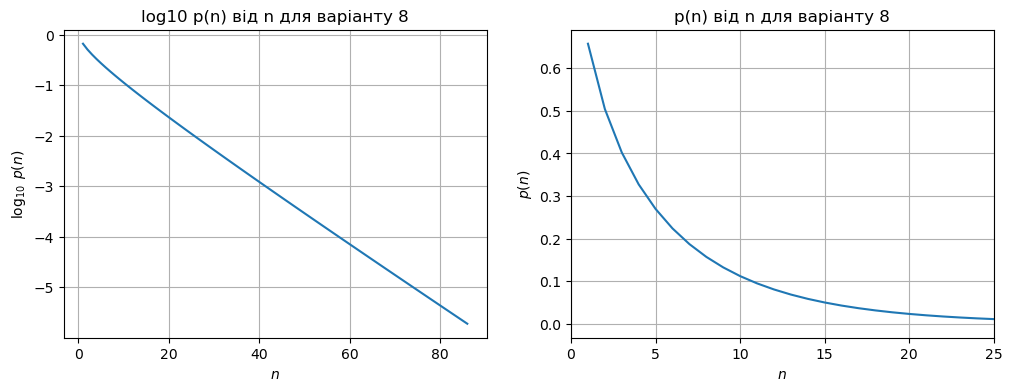

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches((12,4))

ax1.plot(nn,np.log10(pp))
ax1.set_title("log10 p(n) від n для варіанту 8")
ax1.grid(), ax1.set_ylabel("$\log_{10}\; p(n)$"), ax1.set_xlabel("$n$")

ax2.plot(nn,pp)
ax2.set_title("p(n) від n для варіанту 8")
ax2.grid(), ax2.set_ylabel("$p(n)$"), ax2.set_xlabel("$n$")
ax2.set_xlim((0,25))

Також можемо спостерігати, що після $p(85)$ проміжні значення в обчисленні приймають занадто великі значення для 64-бітної змінної з плавуючою точкою (float64), що не дає обчислювати всі наступні ймовірності: $p(86), p(87), ...$. 

In [13]:
pp[84], pp[85], pp[86], pp[87]

(2.1852181616813745e-06, 1.9028554037562384e-06, -inf, -inf)

## Завдання 3
> Розрахувати мiнiмальну кiлькiсть блокiв пiдтвердження, якi гарантують, що iмовiрнiсть
успiшної атаки подвiйної витрати буде не бiльшою нiж $10^{-3}$

- Для заданого фiксованого значення iнтенсивностi створення блокiв $\alpha$ необхiдно написати
програму, яка обчислить значення мiнiмальної кiлькостi блокiв пiдтвердження, що
гарантують ймовiрнiснiсть успiшної атаки подвiйної витрати на рiвнi не бiльше нiж $10^{-3}$

- При цьому розрахунки необхiдно провести в залежностi вiд часу синхронiзацiї $D_H$ (яке
приймає значення з вiдрiзка $[0; 180]$) для рiзних значень хешрейту зловмисника:
для $p_M = 0.15, p_M = 0.25$ i $p_M = 0.4$. Для кожного з трьох значень хешрейту
зловмисника побудувати вiдповiдну таблицю розрахункiв та графiк залежностi
мiнiмальної кiлькостi блокiв пiдтвердження в залежностi вiд часу синхронiзацiї.
Навести теоретичний опис проведених обчислень з вiдповiдним обґрунтуванням.

**Варіант 8:**
- ```
  alpha = 1.1e-3
  ```



Суть завдання полягає в тому, щоб обчислити $\hat n = \min\{n \ge 1 \;:\; p(n) < 10^{-3}\}$ для всіх комбінацій $\left( D_H, p_M \right) \in \left([0;180] \cap \mathbb N_0 \right) \times \{0.15, 0.25, 0.4\}$, де
- $p(n)$ визначена в Завданні 2
- $\alpha$ має константне значення $0.0011$ згідно з варіантом

Нагадаю формулу:
$$p(n) = 1 - \sum_{k=0}^{n-1} P_n(k) \left(1 - \beta^{n-k}\right)$$

**Деталі реалізації**  
Із фіксованими $\left( D_H, p_M \right)$ я ітеративно викликатиму функцію $p(n)$ для зростаючих $n$ з різними кроками. Якщо знайшли достатньо мале значення для кроку $r$, зменшуємо крок та шукаємо більш точно. Нехай кроки будуть $r \in \{50, 10, 1\}$. В будь-якому випадку закінчувати варто кроком 1. Відповідь $\hat n$ визначатиметься умовою $p(\hat n - 1) > 10^{-3}$, а $p(\hat n) < 10^{-3}$.



Також варто пам'ятати про можливість помилки обчислень, що призведе до результату `-inf`. Якщо величина $\hat n$ буде дорівнювати `-inf`, то значить для такої комбінації $\left( D_H, p_M \right)$ цей алгоритм не зможе знайти точну відповідь, бо вона лежить далі, ніж найбільше обчислюване $p(n)$

In [61]:
def find_n(d_h, p_m, alpha, eps=1e-3, debug=False, pn_func=Pn_brute, n_max=300):
    a_m = alpha * p_m
    a_h = alpha - a_m         
    step_sizes = [50, 10, 1]

    left_n = 1
    left_val = pn_func(a_h, a_m, d_h, 1)
    right_n = None
    right_val = None

    for r in step_sizes:
        while True:
            right_n = left_n + r
            right_val = pn_func(a_h, a_m, d_h, right_n)
            if right_val < eps or not mp.isnormal(right_val) or right_n >= n_max:
                break
            left_n = right_n
            left_val = right_val
        if debug: print(f'phase-{r} finished: {right_n}')
    
    if debug and not mp.isnormal(right_val):
        print("Not enough precision.")
    return right_n, right_val


Наступний блок коду - це перевірка, чи працює алгоритм для різних правильних значень n та простої функції F.

In [15]:
def test_find_n(F, eps): 
    step_sizes = [50, 10, 1]

    left_n = 1
    left_val = F(1)
    right_n = None
    right_val = None

    for r in step_sizes:
        while True:
            right_n = left_n + r
            right_val = F(right_n)
            if right_val < eps:
                break
            left_n = right_n
            left_val = right_val
    
    return right_n, right_val

F = lambda x: 250 - x

failed = False
for i in range(0,250):
    n,v = test_find_n(F, i)
    if v != i-1:
        print(f'!{i}, {n}, {v}')
        failed = True
if not failed:
    print('Ok!')

Ok!


Також реалізую примітивну ітеративну фукнцію пошуку значення $\hat n$ для порівняння швидкодії. Ця функція еквівалентна попередній якщо залишити лише одиничний крок

In [62]:
def find_n_brute(d_h, p_m, alpha, eps=1e-3, debug=False, pn_func=Pn_brute, n_max=300):
    a_m = alpha * p_m
    a_h = alpha - a_m         

    left_n = 1
    left_val = pn_func(a_h, a_m, d_h, 1)
    right_n = None
    right_val = None

    while True:
        right_n = left_n + 1
        right_val = pn_func(a_h, a_m, d_h, right_n)
        if right_val < eps or not mp.isnormal(right_val) or right_n >= n_max:
            break
        left_n = right_n
        left_val = right_val
    
    if debug and not mp.isnormal(right_val):
        print("Not enough precision.")
    return right_n, right_val

Перевіряємо на відомій функції $p(n)$ що була обчислена вище (та ж $\alpha$, $D_H = 45$, $p_m \approx 0.319$):

In [17]:
find_n(D_H, alpha_M / alpha, alpha, 1e-3)

(42, 0.0009108217645239608)

Результат збігається з графіком вище.

Далі реалізована утиліта, що запускає пошук $\hat n$ для кожної комбінації параметрів

In [31]:
def find_n_forall_params(d_vals, p_vals, alpha, eps=1e-3, debug=False, pn_func=Pn_brute):
    ans = []
    for i_p, p in enumerate(p_vals):
        subans = []
        for i_d, d in enumerate(d_vals):
            n,val = find_n(d, p, alpha, eps, pn_func=pn_func)
            if not mp.isnormal(val):
                n = 0
            subans.append(n)
            if debug:
                print(f'>{d},{p}')
        ans.append(subans)
    return ans

def find_n_forall_params_brute(d_vals, p_vals, alpha, eps=1e-3, debug=False, pn_func=Pn_brute):
    ans = []
    for i_p, p in enumerate(p_vals):
        subans = []
        for i_d, d in enumerate(d_vals):
            n,val = find_n_brute(d, p, alpha, eps, pn_func=pn_func)
            if not mp.isnormal(val):
                n = 0
            subans.append(n)
            if debug:
                print(f'>{d},{p}')
        ans.append(subans)
    return ans



In [34]:
find_n(0, 0.15, alpha, debug=True)

phase-50 finished: 51
phase-10 finished: 11
phase-1 finished: 2
Not enough precision.


C:\Users\mkrooted\AppData\Local\Temp\ipykernel_16452\1733628209.py:9: RuntimeWarning: divide by zero encountered in divide
  summands = sp.special.factorial(N+ii-1) * sp.special.comb(K, ii) / np.float_power(N*alpha*D_h, ii)
C:\Users\mkrooted\AppData\Local\Temp\ipykernel_16452\1733628209.py:10: RuntimeWarning: invalid value encountered in scalar multiply
  return coef * summands.sum()


(2, nan)

Зверну увагу, що значення $D_H = 0$ призводить до помилок в обчисленні.

Я розглядатиму значення цього параметра виду $5k, k\in\mathbb N$

In [35]:
D_vals = [1] + list(range(5, 181, 5))
p_vals = [0.15, 0.25, 0.4]

t0 = time.time()
Ans1 = find_n_forall_params(d_vals=D_vals, p_vals=p_vals, alpha=alpha, eps=1e-3)
t1 = time.time()
print(f"optimized routine took {t1-t0:.3f}s")

C:\Users\mkrooted\AppData\Local\Temp\ipykernel_16452\1733628209.py:9: RuntimeWarning: overflow encountered in divide
  summands = sp.special.factorial(N+ii-1) * sp.special.comb(K, ii) / np.float_power(N*alpha*D_h, ii)
C:\Users\mkrooted\AppData\Local\Temp\ipykernel_16452\1733628209.py:10: RuntimeWarning: invalid value encountered in scalar multiply
  return coef * summands.sum()
C:\Users\mkrooted\AppData\Local\Temp\ipykernel_16452\1733628209.py:9: RuntimeWarning: overflow encountered in multiply
  summands = sp.special.factorial(N+ii-1) * sp.special.comb(K, ii) / np.float_power(N*alpha*D_h, ii)


optimized routine took 1.340s


In [36]:
t0 = time.time()
Ans2 = find_n_forall_params_brute(d_vals=D_vals, p_vals=p_vals, alpha=alpha, eps=1e-3)
t1 = time.time()
print(f"brute routine took {t1-t0:.3f}s")

C:\Users\mkrooted\AppData\Local\Temp\ipykernel_16452\1733628209.py:9: RuntimeWarning: overflow encountered in divide
  summands = sp.special.factorial(N+ii-1) * sp.special.comb(K, ii) / np.float_power(N*alpha*D_h, ii)
C:\Users\mkrooted\AppData\Local\Temp\ipykernel_16452\1733628209.py:9: RuntimeWarning: overflow encountered in multiply
  summands = sp.special.factorial(N+ii-1) * sp.special.comb(K, ii) / np.float_power(N*alpha*D_h, ii)


brute routine took 3.973s


Бачимо, що з першої спроби оптимізована функція пошуку $\hat n$ дала приріст швидкості у 3 рази. Звісно, одного експерименту зовсім недостатньо для висновків, але це вже гарний показник.

Далі продемонстровано результати обчислень у табличному форматі

In [37]:
def print_results(results, d_vals, p_vals):
    print("p_m", end='')
    for i_d, d in enumerate(d_vals):
        print(f",{d}", end='')
    print()
    for i_p, p in enumerate(p_vals):
        print(f"{p}", end='')
        for val in results[i_p]:
            print(f",{val}", end='')
        print()
    print()
    

print_results(Ans1, D_vals, p_vals)


p_m,1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180
0.15,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,10,10,10,10,10,10,10,10,10,10,10,10,10
0.25,20,20,20,20,20,20,20,20,20,21,21,21,21,21,21,21,21,22,22,22,22,22,22,22,22,23,23,23,23,23,23,23,23,24,24,24,24
0.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



Бачимо, що для $p_M=0.4$ обчислення провалилися. Скоріше за все це через те, що не вистачає точності `float64`. Щоб із цим боротися, я використаю пакет математичних операцій довільної точності `mpmath`

In [44]:
# 2. Обчислення P_n(k) та p(n) з допомогою пакету математичних операцій довільної точності

def Pnk_mp(A_h, A_m, D_h, N, K):
    alpha = A_h + A_m
    p_h = A_h / alpha

    coef = (mp.power(p_h, N)/mp.factorial(N-1)) * (mp.exp(-N*A_m*D_h) * mp.power(N*A_m*D_h, K) / mp.factorial(K))
    sum = 0
    for i in range(0, K+1):
        sum += mp.factorial(N+i-1) * mp.binomial(K, i) / mp.power(N*alpha*D_h, i)
    return coef * sum

def Pn_mp(A_h, A_m, D_h, N):
    p_h = A_h / alpha
    beta = (mp.exp(+A_m*D_h) / p_h) - 1
    if beta > 1: 
        return 1

    sum = 1
    for k in range(0, N):
        sum -= (Pnk_mp(A_h, A_m, D_h, N, k) * (1 - mp.power(beta, N-k)))
    return sum

In [45]:
Pn_mp(alpha_H, alpha_M, D_H, 42)

mpf('0.00091082176452374317')

In [59]:
Pn_mp(alpha*0.6, alpha*0.4, 90, 300)

mpf('1.6898402127877556e-5')

In [58]:
Pn_mp(alpha*0.6, alpha*0.4, 180, 300)

mpf('0.00030696556469391172')

In [64]:
find_n(90, 0.4, alpha, pn_func=Pn_mp)

(178, mpf('0.0009863251007453562'))

Тестові обчислення працюють. Продовжуємо далі.

In [65]:
t0 = time.time()
Ans_mp = find_n_forall_params(d_vals=D_vals, p_vals=p_vals, alpha=alpha, eps=1e-3, pn_func=Pn_mp)
t1 = time.time()
print(f"mp routine took {t1-t0:.3f}s")

mp routine took 496.691s


In [66]:
print_results(Ans_mp, D_vals, p_vals)

p_m,1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180
0.15,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,10,10,10,10,10,10,10,10,10,10,10,10,10
0.25,20,20,20,20,20,20,20,20,20,21,21,21,21,21,21,21,21,22,22,22,22,22,22,22,22,23,23,23,23,23,23,23,23,24,24,24,24
0.4,134,135,137,140,142,144,146,148,151,153,156,158,161,164,166,169,172,175,178,181,184,188,191,195,198,202,206,210,214,218,223,227,232,237,242,247,253



Тепер я отримав точні значення для всіх комбінацій параметрів. Таблицю результатів представлено далі. Перша таблиця - результати обчислень методами python та numpy. Друга таблиця - обчислення з використанням математики довільної точності.

Поміж іншого, можемо бачити, що перші два рядки таблиць збігаються, що є гарним знаком.

![Alt text](tabl1.png)

## Висновки

- Завдяки цій лабораторній роботі я ознайомився із сучасною математичною моделлю блокчейну, що працює на протоколі proof of work, та розробив програму для обчислення серії пов'язаних величин. З іншого боку, я поверхово дослідив застосовність python для обчислень, що включають комбінаторні функції від великих аргументів, та ознайомився з пакетом `mpmath` для обчислень з довільною точністю.
- Обчислення з високою точністю вимагають на порядки більше часу.
- Збільшення часу синхронизації чесних майнерів призводить до збільшення вразливості мережі до DS (double spend) атаки. Наслідком цього бачимо збільшення рекомендованої кількості блоків підтвердження.
- Зловмисники можуть виконати DS атаку з суттєвою ймовірністю навіть з хешрейтом, далеким від 50%. 




---

Джерела

<a id='res1'></a>[1] Lyudmila Kovalchuk, Dmytro Kaidalov, Andrii Nastenko, Mariia Rodinko, Oleksiy Shevtsov,
Roman Oliynykov Decreasing security threshold against double spend attack in networks with
slow synchronization // Computer Communications, Volume 154, 2020, pp. 75-81, ISSN 0140-
3664. doi: 10.1016/j.comcom.2020.01.079.а

<a id='res2'></a>[2] Lyudmila Kovalchuk, Mariia Rodinko, Roman Oliynykov, Dmytro Kaidalov, Andrii Nastenko
Probability of double spend attack for network with non-zero time delay // Publ. Math.
Debrecen Supplementum 100, 2022, pp. 597-615. doi: 10.5486/PMD.2022.Suppl.4

<a id='res3'></a>[3] https://github.com/scipy/scipy/blob/main/scipy/special/cephes/gamma.c